ORIGINAL FROM: https://www.kaggle.com/slawekbiel/positive-score-with-detectron-2-3-training by: @slawekbiel
#### Version history
* V1 - Basic training with default settings
* V2 - Added a custom evaluator to track the competition metric during training

**This new version adds just W&B to monitor better** 

all other code is originally from @slawekbiel

The W&B code is from: https://www.kaggle.com/debarshichanda/pytorch-w-b-jigsaw-starter and https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases

# **Do not forget to go to Add-ons -> Secrets and provide your W&B access token**

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;"> Weights & Biases (W&B) is a set of machine learning tools that helps you build better models faster. <strong>Kaggle competitions require fast-paced model development and evaluation</strong>. There are a lot of components: exploring the training data, training different models, combining trained models in different combinations (ensembling), and so on.</span>

> <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">⏳ Lots of components = Lots of places to go wrong = Lots of time spent debugging</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">W&B can be useful for Kaggle competition with it's lightweight and interoperable tools:</span>

* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Quickly track experiments,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Version and iterate on datasets, <br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Evaluate model performance,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Reproduce models,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Visualize results and spot regressions,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Share findings with colleagues.</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">To learn more about Weights and Biases check out this <strong><a href="https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases">kernel</a></strong>.</span>

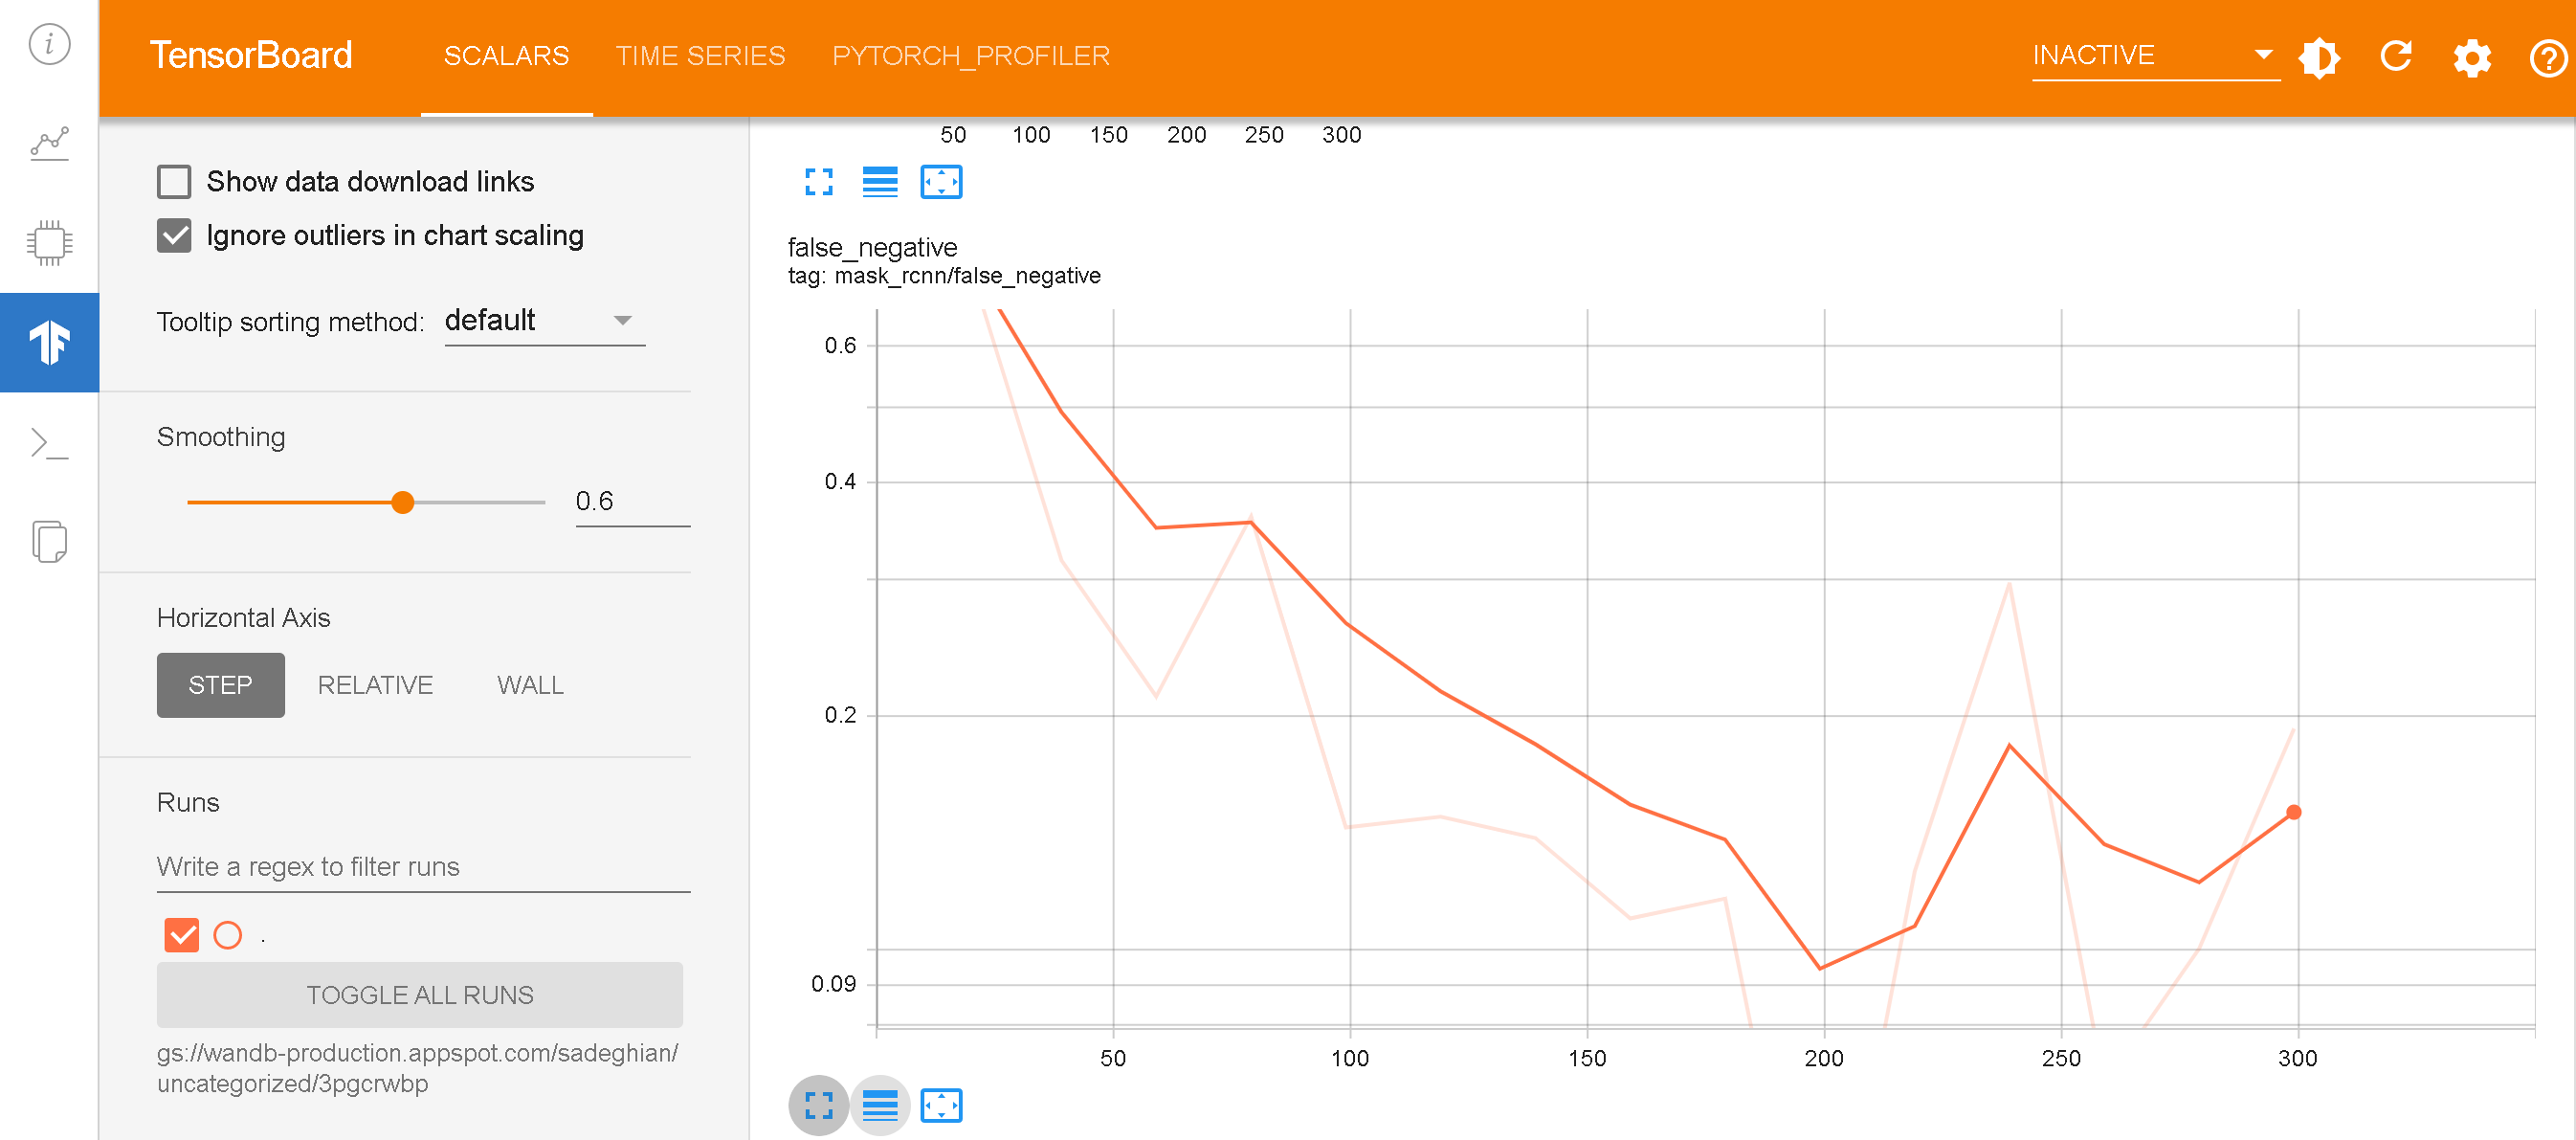
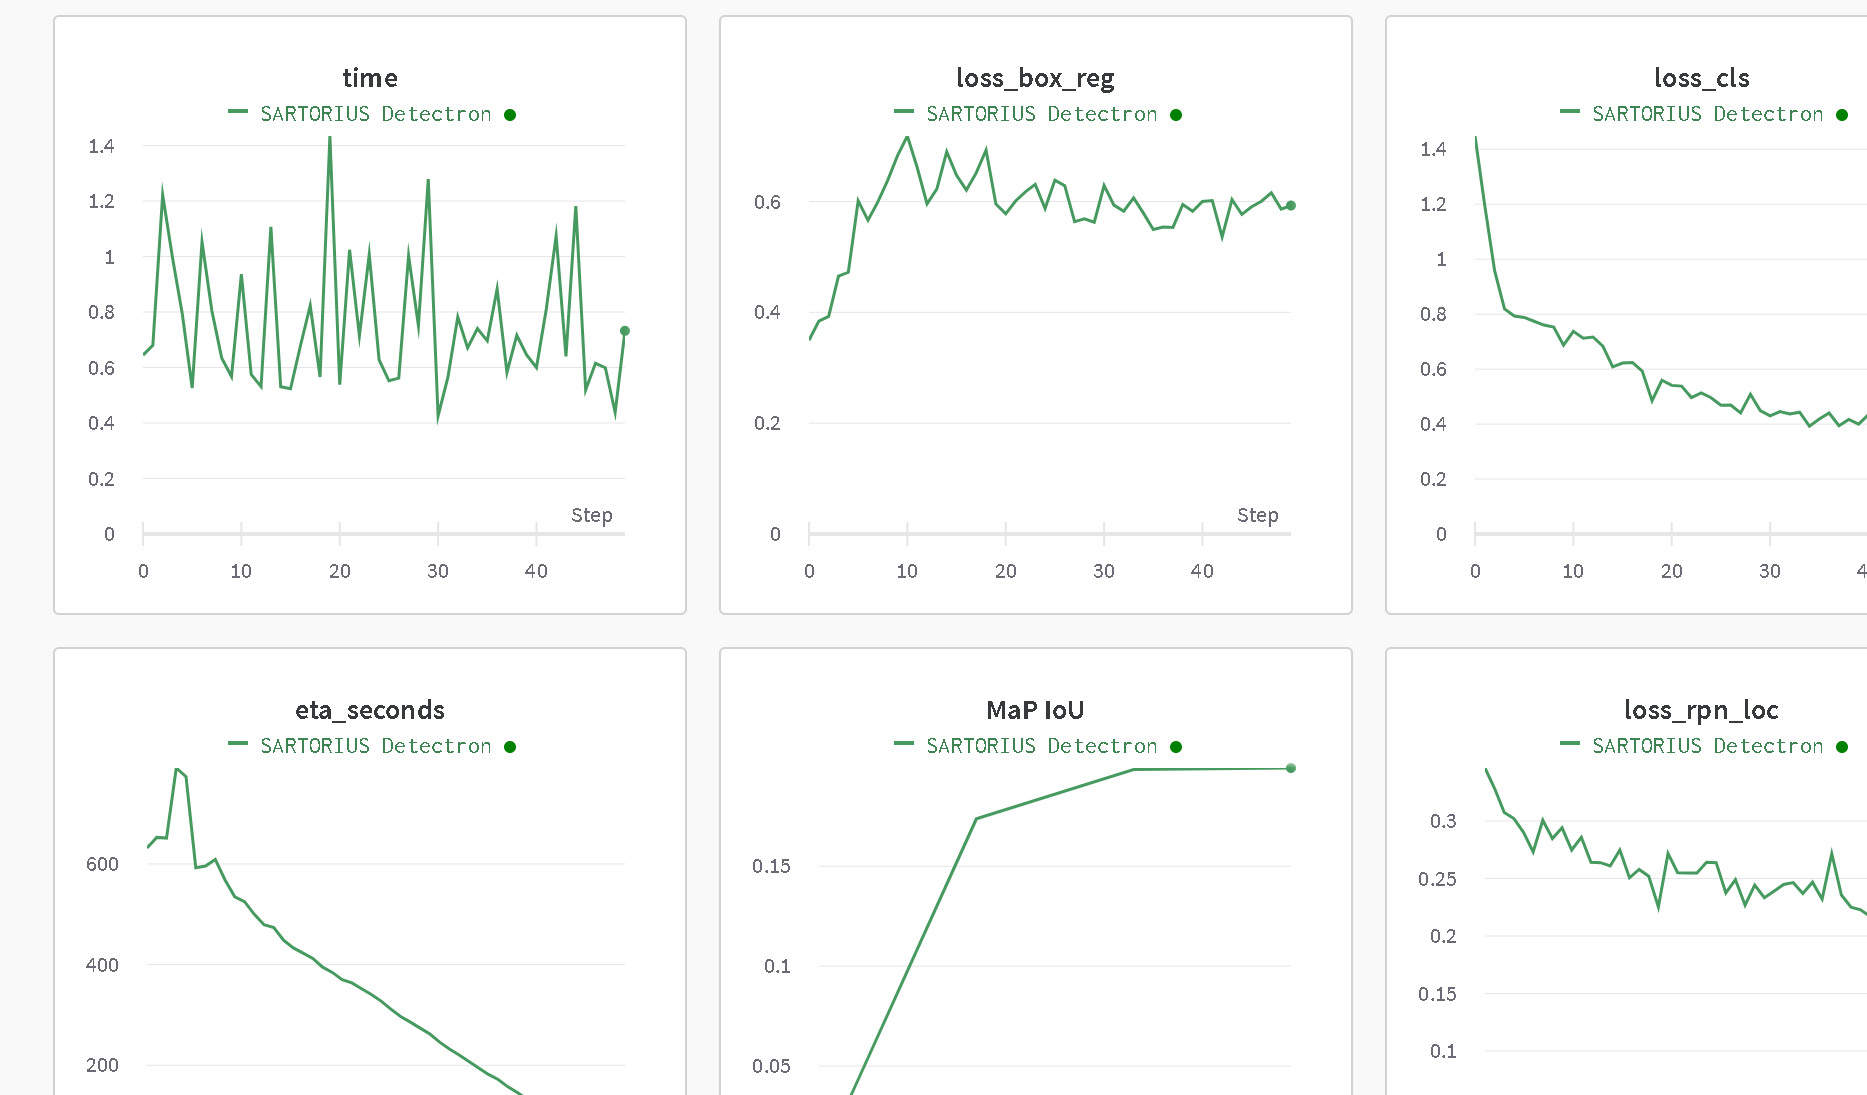

In [ ]:
!pip install --upgrade wandb

In [ ]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
    # Initializing required to be connected to Detectron2
    wandb.init(sync_tensorboard=True, name="SARTORIUS Detectron",
           settings=wandb.Settings(start_method="thread", console="auto"))
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

## Training

All the heavy lifting here is done by the [detectron](https://github.com/facebookresearch/detectron2) library. What's needed from us is pointing it to the annotation files of our dataset (see [part one](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details), setting some hyperparameters and calling `trainer.train()`

Most of the code here is just for displaying things to make sure everything is set up correctly and the training worked.

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
setup_logger()

### Load the competition data
This is very simple once we have our data in the COCO format. See the [part one notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details.

In [ ]:
dataDir=Path('../input/sartorius-cell-instance-segmentation/')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, '../input/sartorius-cell-instance-segmentation-coco/annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'../input/sartorius-cell-instance-segmentation-coco/annotations_val.json', dataDir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

### Display a sample file to check the data is loaded correctly

In [ ]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

### Define evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [ ]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    

### Train
I haven't done any hyperparameter optimization yet, this is mostly taken as is from the Detectron tutorial. 

Training for 1000 iterations here for demonstration. For a high scoring model you will need to train it longer, closer to 10000 with these settings

In [ ]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 1000    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

### Lets look at some of the validation files to check if things look reasonable
We show predictions on the left and ground truth on the right

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

### We can see that while it is not perfect, it did learn something
We can now take our model file and use it to generate submission in the [final notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-3-3-inference)

In [ ]:
!ls ./output/model_final.pth